# RDKit Chemical Compound Analyzer
Comprehensive chemical analysis including format conversion, property calculation, fingerprints, substructure analysis, charge neutralization, and stereochemistry


## 1. Import Libraries

In [54]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, Fragments, Lipinski
from rdkit.Chem import rdMolDescriptors, rdmolops, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.DataStructs import TanimotoSimilarity, BulkTanimotoSimilarity
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import PandasTools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML,Image
import numpy as np
from rdkit.Chem import rdFingerprintGenerator

# Configure visualization
IPythonConsole.ipython_useSVG = True
sns.set_style("whitegrid")

## 2. Input Your Molecule
# Enter your molecule as SMILES, InChI, or MOL block

In [55]:
SAMPLE_MOLECULES = {
    'Aspirin': 'CC(=O)Oc1ccccc1C(=O)O',
    'Caffeine': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
    'Penicillin G': 'CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O',
    'Ibuprofen': 'CC(C)Cc1ccc(cc1)C(C)C(=O)O',
    'Morphine': 'CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O'
}

# Select or input your molecule
input_smiles = SAMPLE_MOLECULES['Morphine']  # Change this to your molecule
print(f"Working with: {input_smiles}")


Working with: CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O


## 3. Parse and Validate Molecule


In [56]:
def parse_molecule(input_str, input_format='smiles'):
    """Parse molecule from various formats"""
    if input_format == 'smiles':
        mol = Chem.MolFromSmiles(input_str)
    elif input_format == 'inchi':
        mol = Chem.MolFromInchi(input_str)
    elif input_format in ['mol', 'sdf']:
        mol = Chem.MolFromMolBlock(input_str)
    else:
        mol = Chem.MolFromSmiles(input_str)
    
    if mol is None:
        raise ValueError(f"Failed to parse molecule from {input_format}")
    
    return mol

# Parse the molecule
mol = parse_molecule(input_smiles)
print("✓ Molecule parsed successfully")
print(f"Molecular Formula: {rdMolDescriptors.CalcMolFormula(mol)}")

✓ Molecule parsed successfully
Molecular Formula: C17H19NO3


## 4. Visualize Molecule


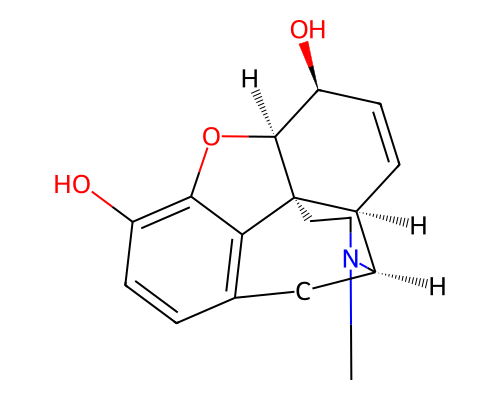

In [57]:
def draw_molecule_2d(mol, size=(400, 300), kekulize=True):
    """Draw molecule with enhanced visualization"""
    if kekulize:
        mol_copy = Chem.Mol(mol)
        Chem.Kekulize(mol_copy)
        return Draw.MolToImage(mol_copy, size=size)
    return Draw.MolToImage(mol, size=size)

# Display the molecule
img = draw_molecule_2d(mol, size=(500, 400))
display(img)

## 5. Format Conversion


In [58]:
def convert_to_all_formats(mol):
    """Convert molecule to multiple chemical formats"""
    formats = pd.DataFrame({
        'Format': [
            'SMILES',
            'Canonical SMILES',
            'Isomeric SMILES',
            'InChI',
            'InChIKey',
            'Molecular Formula'
        ],
        'Value': [
            Chem.MolToSmiles(mol),
            Chem.MolToSmiles(mol, canonical=True),
            Chem.MolToSmiles(mol, isomericSmiles=True),
            Chem.MolToInchi(mol),
            Chem.MolToInchiKey(mol),
            rdMolDescriptors.CalcMolFormula(mol)
        ]
    })
    return formats

formats_df = convert_to_all_formats(mol)
display(formats_df)

,Format,Value
0,SMILES,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H...
1,Canonical SMILES,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H...
2,Isomeric SMILES,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H...
3,InChI,InChI=1S/C17H19NO3/c1-18-7-6-17-10-3-5-13(20)1...
4,InChIKey,BQJCRHHNABKAKU-KBQPJGBKSA-N
5,Molecular Formula,C17H19NO3


## 6. Calculate Molecular Properties


In [59]:
def calculate_comprehensive_properties(mol):
    """Calculate extensive molecular properties"""
    props = {
        # Basic Properties
        'Molecular Weight': Descriptors.MolWt(mol),
        'Exact Mass': Descriptors.ExactMolWt(mol),
        'Heavy Atom Count': Descriptors.HeavyAtomCount(mol),
        'Number of Atoms': mol.GetNumAtoms(),
        'Number of Bonds': mol.GetNumBonds(),
        
        # Lipinski's Rule of Five
        'LogP': Descriptors.MolLogP(mol),
        'H-Bond Donors': Descriptors.NumHDonors(mol),
        'H-Bond Acceptors': Descriptors.NumHAcceptors(mol),
        'Rotatable Bonds': Descriptors.NumRotatableBonds(mol),
        
        # Additional Descriptors
        'TPSA': Descriptors.TPSA(mol),
        'Molar Refractivity': Descriptors.MolMR(mol),
        'Fraction Csp3': Lipinski.FractionCSP3(mol),
        'Number of Rings': Descriptors.RingCount(mol),
        'Aromatic Rings': Descriptors.NumAromaticRings(mol),
        'Aliphatic Rings': Descriptors.NumAliphaticRings(mol),
        'Saturated Rings': Descriptors.NumSaturatedRings(mol),
        
        # Charge and Polarity
        'Formal Charge': Chem.GetFormalCharge(mol),
        
        # Stereochemistry
        'Chiral Centers': len(Chem.FindMolChiralCenters(mol, includeUnassigned=True)),
        'Defined Stereocenters': len(Chem.FindMolChiralCenters(mol)),
    }
    
    # Lipinski violations
    violations = 0
    if props['Molecular Weight'] > 500: violations += 1
    if props['LogP'] > 5: violations += 1
    if props['H-Bond Donors'] > 5: violations += 1
    if props['H-Bond Acceptors'] > 10: violations += 1
    props['Lipinski Violations'] = violations
    props['Drug-like (Lipinski)'] = 'Yes' if violations <= 1 else 'No'
    
    return props

props = calculate_comprehensive_properties(mol)
props_df = pd.DataFrame(list(props.items()), columns=['Property', 'Value'])
display(props_df.style.set_properties(**{'text-align': 'left'}))


,Property,Value
0,Molecular Weight,285.343000
1,Exact Mass,285.136493
2,Heavy Atom Count,21
3,Number of Atoms,21
4,Number of Bonds,25
5,LogP,1.198100
6,H-Bond Donors,2
7,H-Bond Acceptors,4
8,Rotatable Bonds,0
9,TPSA,52.930000


## 7. Generate and Analyze Fingerprints

,Fingerprint Type,Total Bits,Bits Set,Density
0,"Morgan (R=2, 2048 bits)",2048,46,2.25%
1,"Morgan (R=3, 2048 bits)",2048,64,3.12%
2,RDKit Topological,2048,1497,73.10%
3,MACCS Keys (166 bits),167,48,28.74%
4,Atom Pair,2048,171,8.35%
5,Topological Torsion,2048,63,3.08%


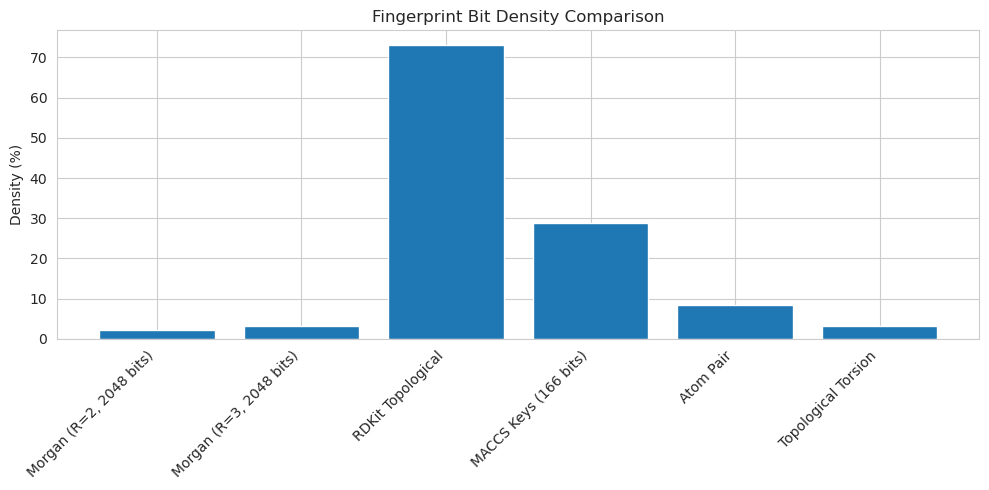

In [60]:
def generate_all_fingerprints(mol):
    """Generate various molecular fingerprints"""
    morgan_generator_r2 = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    morgan_generator_r3 = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
    fps = {
        'Morgan (R=2, 2048 bits)': morgan_generator_r2.GetFingerprint(mol),
        'Morgan (R=3, 2048 bits)': morgan_generator_r3.GetFingerprint(mol),
        'RDKit Topological': Chem.RDKFingerprint(mol),
        'MACCS Keys (166 bits)': AllChem.GetMACCSKeysFingerprint(mol),
        'Atom Pair': rdFingerprintGenerator.GetAtomPairGenerator().GetFingerprint(mol),
        # 'Topological Torsion': AllChem.GetTopologicalTorsionFingerprint(mol),
        "Topological Torsion": rdFingerprintGenerator.GetTopologicalTorsionGenerator().GetFingerprint(mol)
    }
    return fps

fingerprints = generate_all_fingerprints(mol)
# Display fingerprint information
fp_info = []
for name, fp in fingerprints.items():
    fp_info.append({
        'Fingerprint Type': name,
        'Total Bits': len(fp),
        'Bits Set': fp.GetNumOnBits(),
        'Density': f"{fp.GetNumOnBits()/len(fp)*100:.2f}%"
    })

fp_df = pd.DataFrame(fp_info)
display(fp_df)

# Visualize fingerprint density
plt.figure(figsize=(10, 5))
plt.bar(range(len(fp_info)), [float(item['Density'].rstrip('%')) for item in fp_info])
plt.xticks(range(len(fp_info)), [item['Fingerprint Type'] for item in fp_info], rotation=45, ha='right')
plt.ylabel('Density (%)')
plt.title('Fingerprint Bit Density Comparison')
plt.tight_layout()
plt.show()

## 8. Substructure Analysis and Scaffolds

Original Molecule vs Scaffolds:


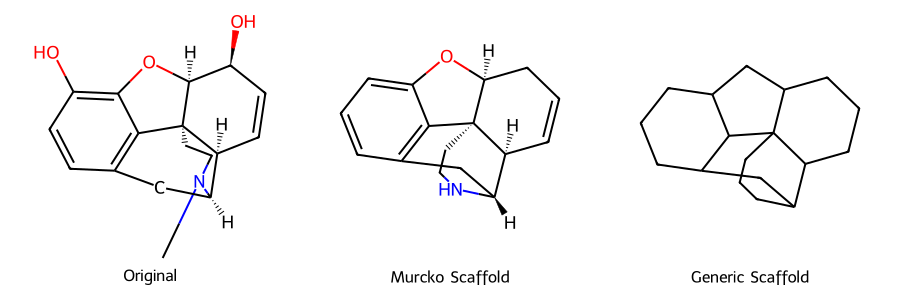


Functional Groups Present:


,Functional Group,Count
0,Alcohols,1
1,Tertiary Amines,1
2,Aromatic Rings,1
3,Phenols,1


In [61]:
def analyze_substructures(mol):
    """Extract and analyze molecular substructures"""
    results = {}
    
    # Murcko Scaffold
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        results['Murcko Scaffold'] = Chem.MolToSmiles(scaffold)
        results['Murcko Scaffold Mol'] = scaffold
        
        # Generic scaffold
        generic_scaffold = MurckoScaffold.MakeScaffoldGeneric(scaffold)
        results['Generic Scaffold'] = Chem.MolToSmiles(generic_scaffold)
        results['Generic Scaffold Mol'] = generic_scaffold
    except:
        results['Murcko Scaffold'] = 'N/A'
        results['Generic Scaffold'] = 'N/A'
    
    # Ring systems
    ring_info = mol.GetRingInfo()
    results['Number of Rings'] = ring_info.NumRings()
    results['Ring Sizes'] = [len(ring) for ring in ring_info.AtomRings()]
    
    # Functional groups
    fg_counts = {
        'Alcohols': Fragments.fr_Al_OH(mol),
        'Aldehydes': Fragments.fr_aldehyde(mol),
        'Ketones': Fragments.fr_ketone(mol),
        'Carboxylic Acids': Fragments.fr_COO(mol),
        'Esters': Fragments.fr_ester(mol),
        'Primary Amines': Fragments.fr_NH2(mol),
        'Secondary Amines': Fragments.fr_NH1(mol),
        'Tertiary Amines': Fragments.fr_NH0(mol),
        'Amides': Fragments.fr_amide(mol),
        'Aromatic Rings': Fragments.fr_benzene(mol),
        'Halides': Fragments.fr_halogen(mol),
        'Phenols': Fragments.fr_phenol(mol),
        'Nitro Groups': Fragments.fr_nitro(mol),
    }
    
    results['Functional Groups'] = {k: v for k, v in fg_counts.items() if v > 0}
    
    return results

substructures = analyze_substructures(mol)

# Display scaffolds
if 'Murcko Scaffold Mol' in substructures:
    print("Original Molecule vs Scaffolds:")
    mols_to_draw = [mol, substructures['Murcko Scaffold Mol'], substructures['Generic Scaffold Mol']]
    legends = ['Original', 'Murcko Scaffold', 'Generic Scaffold']
    img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=3, subImgSize=(300, 300), legends=legends)
    display(img)

# Display functional groups
if substructures['Functional Groups']:
    print("\nFunctional Groups Present:")
    fg_df = pd.DataFrame(list(substructures['Functional Groups'].items()), 
                         columns=['Functional Group', 'Count'])
    display(fg_df)
else:
    print("No common functional groups detected")

## 9. Charge Neutralization

In [62]:
def neutralize_molecule(mol):
    """Neutralize charged molecules"""
    uncharger = rdMolStandardize.Uncharger()
    neutral_mol = uncharger.uncharge(Chem.Mol(mol))
    
    results = {
        'Original Charge': Chem.GetFormalCharge(mol),
        'Neutralized Charge': Chem.GetFormalCharge(neutral_mol),
        'Original SMILES': Chem.MolToSmiles(mol),
        'Neutralized SMILES': Chem.MolToSmiles(neutral_mol),
        'Neutralized Mol': neutral_mol
    }
    
    return results

neutralization = neutralize_molecule(mol)

# Display results
print(f"Original Charge: {neutralization['Original Charge']}")
print(f"Neutralized Charge: {neutralization['Neutralized Charge']}")

if neutralization['Original Charge'] != neutralization['Neutralized Charge']:
    print("\nComparison:")
    mols_compare = [mol, neutralization['Neutralized Mol']]
    legends = ['Original (Charged)', 'Neutralized']
    img = Draw.MolsToGridImage(mols_compare, molsPerRow=2, subImgSize=(300, 300), legends=legends)
    display(img)
else:
    print("Molecule is already neutral")

Original Charge: 0
Neutralized Charge: 0
Molecule is already neutral


[23:08:30] Running Uncharger


## 10. Stereochemistry Analysis

In [63]:
def analyze_stereochemistry(mol):
    """Comprehensive stereochemistry analysis"""
    stereo_info = {
        'Has Stereochemistry': False,
        'Chiral Centers': [],
        'Double Bond Stereo': [],
        'Num Unspecified Stereo': 0
    }
    
    # Find chiral centers
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    if chiral_centers:
        stereo_info['Has Stereochemistry'] = True
        stereo_info['Chiral Centers'] = [
            {
                'Atom Index': idx, 
                'Chirality': chirality,
                'Atom Symbol': mol.GetAtomWithIdx(idx).GetSymbol()
            } 
            for idx, chirality in chiral_centers
        ]
    
    # Check double bond stereochemistry
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            stereo = bond.GetStereo()
            if stereo != Chem.BondStereo.STEREONONE:
                stereo_info['Has Stereochemistry'] = True
                begin_atom = bond.GetBeginAtom()
                end_atom = bond.GetEndAtom()
                stereo_info['Double Bond Stereo'].append({
                    'Bond Index': bond.GetIdx(),
                    'Atoms': f"{begin_atom.GetSymbol()}{bond.GetBeginAtomIdx()}-{end_atom.GetSymbol()}{bond.GetEndAtomIdx()}",
                    'Stereo Type': str(stereo)
                })
    
    # Count unspecified stereocenters
    unspecified = len([c for c in chiral_centers if c[1] == '?'])
    stereo_info['Num Unspecified Stereo'] = unspecified
    
    return stereo_info

stereo_analysis = analyze_stereochemistry(mol)

print(f"Has Stereochemistry: {stereo_analysis['Has Stereochemistry']}")
print(f"Number of Chiral Centers: {len(stereo_analysis['Chiral Centers'])}")
print(f"Unspecified Stereocenters: {stereo_analysis['Num Unspecified Stereo']}")

if stereo_analysis['Chiral Centers']:
    print("\nChiral Centers:")
    chiral_df = pd.DataFrame(stereo_analysis['Chiral Centers'])
    display(chiral_df)

if stereo_analysis['Double Bond Stereo']:
    print("\nDouble Bond Stereochemistry:")
    bond_df = pd.DataFrame(stereo_analysis['Double Bond Stereo'])
    display(bond_df)


Has Stereochemistry: True
Number of Chiral Centers: 5
Unspecified Stereocenters: 0

Chiral Centers:


,Atom Index,Chirality,Atom Symbol
0,4,S,C
1,5,R,C
2,6,R,C
3,16,R,C
4,17,S,C


## 11. Similarity Search

,SMILES,Tanimoto Similarity
0,CC(C)Cc1ccc(cc1)C(C)C(=O)O,0.0923
1,CC(=O)Oc1ccccc1C(=O)O,0.0769
2,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,0.0758
3,c1ccc(cc1)C(=O)O,0.0714


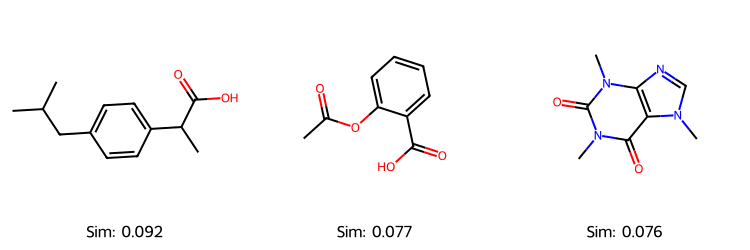

In [64]:
def calculate_similarity_matrix(query_mol, comparison_smiles_list):
    """Calculate similarity between query and multiple molecules"""
    
    
    query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=2048)
    
    similarities = []
    for smiles in comparison_smiles_list:
        comp_mol = Chem.MolFromSmiles(smiles)
        if comp_mol:
            comp_fp = AllChem.GetMorganFingerprintAsBitVect(comp_mol, 2, nBits=2048)
            sim = TanimotoSimilarity(query_fp, comp_fp)
            similarities.append({
                'SMILES': smiles,
                'Similarity': sim,
                'Molecule': comp_mol
            })
    
    return sorted(similarities, key=lambda x: x['Similarity'], reverse=True)

def calculate_similarity_matrix_new(query_mol, comparison_smiles_list):
    """Calculate similarity between query and multiple molecules"""

    fp = rdFingerprintGenerator.GetMorganGenerator(2,fpSize=2048)
    query_fp = fp.GetFingerprint(query_mol)

    similarities = []
    for smiles in comparison_smiles_list:
        comp_mol = Chem.MolFromSmiles(smiles)
        if comp_mol:
            comp_fp = fp.GetFingerprint(comp_mol)
            sim = TanimotoSimilarity(query_fp,comp_fp)
            similarities.append({
                'SMILES': smiles,
                'Similarity': sim,
                'Molecule': comp_mol
            })
    return sorted(similarities, key=lambda x: x['Similarity'], reverse=True)


# Example: Compare with other molecules
comparison_molecules = [
    'CC(=O)Oc1ccccc1C(=O)O',  # Aspirin
    'CC(C)Cc1ccc(cc1)C(C)C(=O)O',  # Ibuprofen
    'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',  # Caffeine
    'c1ccc(cc1)C(=O)O',  # Benzoic acid
]

# similarities = calculate_similarity_matrix(mol,comparison_molecules)
similarities = calculate_similarity_matrix_new(mol, comparison_molecules)

# Display results
sim_data = []
for item in similarities:
    sim_data.append({
        'SMILES': item['SMILES'],
        'Tanimoto Similarity': f"{item['Similarity']:.4f}"
    })

sim_df = pd.DataFrame(sim_data)
display(sim_df)

# Visualize similar molecules
if similarities:
    top_similar = similarities[:3]
    mols_similar = [item['Molecule'] for item in top_similar]
    legends = [f"Sim: {item['Similarity']:.3f}" for item in top_similar]
    img = Draw.MolsToGridImage(mols_similar, molsPerRow=3, subImgSize=(250, 250), legends=legends)
    display(img)


## 12. Advanced Drawing Options

Aromatic atoms: [8, 9, 10, 11, 12, 13]


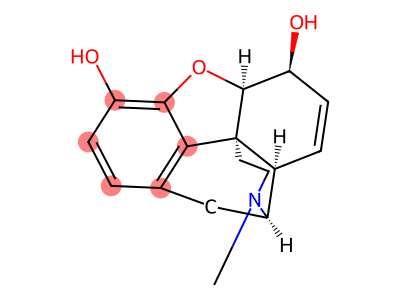

In [65]:
def draw_molecule_with_highlighting(mol, highlight_atoms=None, highlight_bonds=None):
    """Draw molecule with atom/bond highlighting"""
    drawer = rdMolDraw2D.MolDraw2DCairo(400, 300)
    
    if highlight_atoms or highlight_bonds:
        highlight_atoms = highlight_atoms or []
        highlight_bonds = highlight_bonds or []
        drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightBonds=highlight_bonds)
    else:
        drawer.DrawMolecule(mol)
    
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

# Example: Highlight aromatic atoms
aromatic_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIsAromatic()]
print(f"Aromatic atoms: {aromatic_atoms}")

if aromatic_atoms:
    from IPython.display import SVG
    png = draw_molecule_with_highlighting(mol, highlight_atoms=aromatic_atoms)
    display(Image(data=png))

## 13. Batch Analysis Function

,Name,SMILES,Molecular Weight,LogP,H-Bond Donors,H-Bond Acceptors,TPSA,Drug-like (Lipinski),Exact Mass,Heavy Atom Count,...,Molar Refractivity,Fraction Csp3,Number of Rings,Aromatic Rings,Aliphatic Rings,Saturated Rings,Formal Charge,Chiral Centers,Defined Stereocenters,Lipinski Violations
0,Aspirin,CC(=O)Oc1ccccc1C(=O)O,180.159,1.3101,1,3,63.60,Yes,180.042259,13,...,44.7103,0.111111,1,1,0,0,0,0,0,0
1,Caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,194.194,-1.0293,0,6,61.82,Yes,194.080376,14,...,51.1960,0.375000,2,2,0,0,0,0,0,0
2,Penicillin G,CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O,334.397,0.8608,2,4,86.71,Yes,334.098728,23,...,85.8045,0.437500,3,1,2,2,0,3,0,0
3,Ibuprofen,CC(C)Cc1ccc(cc1)C(C)C(=O)O,206.285,3.0732,1,1,37.30,Yes,206.130680,15,...,61.0348,0.461538,1,1,0,0,0,1,0,0
4,Morphine,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,285.343,1.1981,2,4,52.93,Yes,285.136493,21,...,77.5766,0.529412,5,1,4,1,0,5,5,0


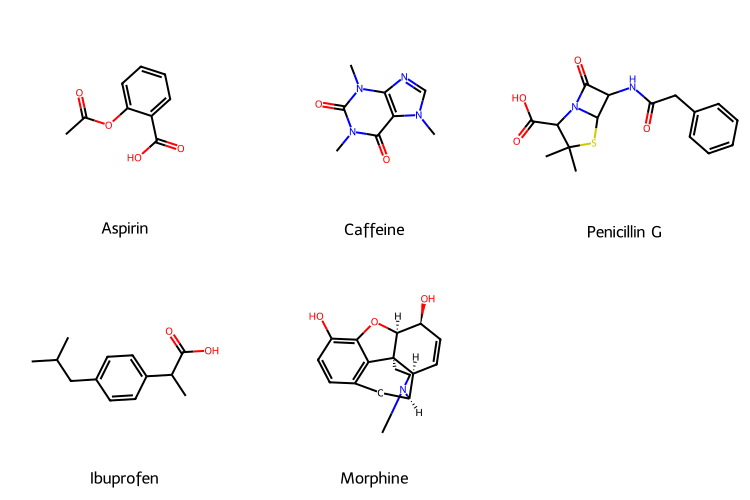

✓ Results exported:
  - my_molecule_structure.png
  - my_molecule_properties.csv
  - my_molecule.sdf
  - my_molecule_formats.csv


In [66]:
def batch_analyze_molecules(smiles_list, names=None):
    """Analyze multiple molecules at once"""
    if names is None:
        names = [f"Mol_{i+1}" for i in range(len(smiles_list))]
    
    results = []
    mols = []
    
    for name, smiles in zip(names, smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            props = calculate_comprehensive_properties(mol)
            props['Name'] = name
            props['SMILES'] = smiles
            results.append(props)
            mols.append(mol)
    
    df = pd.DataFrame(results)
    
    # Reorder columns
    cols = ['Name', 'SMILES', 'Molecular Weight', 'LogP', 'H-Bond Donors', 
            'H-Bond Acceptors', 'TPSA', 'Drug-like (Lipinski)']
    cols = [c for c in cols if c in df.columns]
    other_cols = [c for c in df.columns if c not in cols]
    df = df[cols + other_cols]
    
    return df, mols

# Example batch analysis
batch_smiles = list(SAMPLE_MOLECULES.values())
batch_names = list(SAMPLE_MOLECULES.keys())

batch_df, batch_mols = batch_analyze_molecules(batch_smiles, batch_names)
display(batch_df)

# Visualize batch
img = Draw.MolsToGridImage(batch_mols, molsPerRow=3, subImgSize=(250, 250), 
                           legends=batch_names)
display(img)

# %% [markdown]
## 14. Export Results

# %%
def export_analysis_results(mol, filename_base='molecule_analysis'):
    """Export analysis results to files"""
    
    # 1. Save molecule image
    img = draw_molecule_2d(mol, size=(800, 600))
    img.save(f'{filename_base}_structure.png')
    
    # 2. Save properties to CSV
    props = calculate_comprehensive_properties(mol)
    props_df = pd.DataFrame(list(props.items()), columns=['Property', 'Value'])
    props_df.to_csv(f'{filename_base}_properties.csv', index=False)
    
    # 3. Save SDF file
    writer = Chem.SDWriter(f'{filename_base}.sdf')
    writer.write(mol)
    writer.close()
    
    # 4. Save formats
    formats = convert_to_all_formats(mol)
    formats.to_csv(f'{filename_base}_formats.csv', index=False)
    
    print(f"✓ Results exported:")
    print(f"  - {filename_base}_structure.png")
    print(f"  - {filename_base}_properties.csv")
    print(f"  - {filename_base}.sdf")
    print(f"  - {filename_base}_formats.csv")

# Uncomment to export
export_analysis_results(mol, 'my_molecule')


## 15. Summary Report

In [67]:
def generate_summary_report(mol):
    """Generate a comprehensive summary report"""
    print("=" * 80)
    print("COMPREHENSIVE MOLECULAR ANALYSIS REPORT")
    print("=" * 80)
    
    # Basic info
    print("\n1. BASIC INFORMATION")
    print("-" * 80)
    print(f"SMILES: {Chem.MolToSmiles(mol)}")
    print(f"Molecular Formula: {rdMolDescriptors.CalcMolFormula(mol)}")
    print(f"InChIKey: {Chem.MolToInchiKey(mol)}")
    
    # Properties
    props = calculate_comprehensive_properties(mol)
    print("\n2. DRUG-LIKENESS (Lipinski's Rule of Five)")
    print("-" * 80)
    print(f"Molecular Weight: {props['Molecular Weight']:.2f} (≤500)")
    print(f"LogP: {props['LogP']:.2f} (≤5)")
    print(f"H-Bond Donors: {props['H-Bond Donors']} (≤5)")
    print(f"H-Bond Acceptors: {props['H-Bond Acceptors']} (≤10)")
    print(f"Violations: {props['Lipinski Violations']}")
    print(f"Drug-like: {props['Drug-like (Lipinski)']}")
    
    # Structure features
    print("\n3. STRUCTURAL FEATURES")
    print("-" * 80)
    print(f"Heavy Atoms: {props['Heavy Atom Count']}")
    print(f"Rotatable Bonds: {props['Rotatable Bonds']}")
    print(f"Aromatic Rings: {props['Aromatic Rings']}")
    print(f"Chiral Centers: {props['Chiral Centers']}")
    print(f"TPSA: {props['TPSA']:.2f} Ų")
    
    # Functional groups
    subs = analyze_substructures(mol)
    if subs['Functional Groups']:
        print("\n4. FUNCTIONAL GROUPS")
        print("-" * 80)
        for fg, count in subs['Functional Groups'].items():
            print(f"{fg}: {count}")
    
    print("\n" + "=" * 80)

generate_summary_report(mol)

COMPREHENSIVE MOLECULAR ANALYSIS REPORT

1. BASIC INFORMATION
--------------------------------------------------------------------------------
SMILES: CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5
Molecular Formula: C17H19NO3
InChIKey: BQJCRHHNABKAKU-KBQPJGBKSA-N

2. DRUG-LIKENESS (Lipinski's Rule of Five)
--------------------------------------------------------------------------------
Molecular Weight: 285.34 (≤500)
LogP: 1.20 (≤5)
H-Bond Donors: 2 (≤5)
H-Bond Acceptors: 4 (≤10)
Violations: 0
Drug-like: Yes

3. STRUCTURAL FEATURES
--------------------------------------------------------------------------------
Heavy Atoms: 21
Rotatable Bonds: 0
Aromatic Rings: 1
Chiral Centers: 5
TPSA: 52.93 Ų

4. FUNCTIONAL GROUPS
--------------------------------------------------------------------------------
Alcohols: 1
Tertiary Amines: 1
Aromatic Rings: 1
Phenols: 1

